## Remove cancer type experiments

In our previous experiments, we were comparing pancancer mutation prediction (train a model on all cancer types, then test on a single cancer type) with single-cancer mutation prediction (train and test on the same single cancer type).

Here, we want to find out what happens to performance when we remove the relevant cancer type from the pancancer training set (i.e. train on all cancer types minus the one we test on). We plan to compare this with the pancancer results, under the assumption that this should be detrimental to performance.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
single_cancer_dir = os.path.join(cfg.results_dir, 'single_cancer')
pancancer_dir = os.path.join(cfg.results_dir, 'pancancer')
remove_cancer_dir = os.path.join(cfg.results_dir, 'pancancer_only')

In [3]:
single_cancer_df = au.load_prediction_results(single_cancer_dir, 'single_cancer')
print(single_cancer_df.shape)
single_cancer_df.head()

(10464, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.99987,0.99879,MAP3K1,BRCA,signal,42,train,0,single_cancer,MAP3K1_BRCA
1,0.72689,0.46638,MAP3K1,BRCA,signal,42,test,0,single_cancer,MAP3K1_BRCA
2,0.72844,0.38910,MAP3K1,BRCA,signal,42,cv,0,single_cancer,MAP3K1_BRCA
3,0.99860,0.98630,MAP3K1,BRCA,signal,42,train,1,single_cancer,MAP3K1_BRCA
4,0.74887,0.48700,MAP3K1,BRCA,signal,42,test,1,single_cancer,MAP3K1_BRCA


In [4]:
pancancer_df = au.load_prediction_results(pancancer_dir, 'pancancer')
print(pancancer_df.shape)
pancancer_df.head()

(10464, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.95820,0.68399,MAP3K1,BRCA,signal,42,train,0,pancancer,MAP3K1_BRCA
1,0.69619,0.40796,MAP3K1,BRCA,signal,42,test,0,pancancer,MAP3K1_BRCA
2,0.62527,0.20878,MAP3K1,BRCA,signal,42,cv,0,pancancer,MAP3K1_BRCA
3,0.98367,0.82884,MAP3K1,BRCA,signal,42,train,1,pancancer,MAP3K1_BRCA
4,0.77170,0.44885,MAP3K1,BRCA,signal,42,test,1,pancancer,MAP3K1_BRCA


In [5]:
remove_cancer_df = au.load_prediction_results(remove_cancer_dir, 'pancancer_only')
print(remove_cancer_df.shape)
remove_cancer_df.head()

(7692, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.97197,0.631140,MAP3K1,BRCA,signal,42,train,0,pancancer_only,MAP3K1_BRCA
1,0.42925,0.096007,MAP3K1,BRCA,signal,42,test,0,pancancer_only,MAP3K1_BRCA
2,0.66176,0.086703,MAP3K1,BRCA,signal,42,cv,0,pancancer_only,MAP3K1_BRCA
3,0.97197,0.631140,MAP3K1,BRCA,signal,42,train,1,pancancer_only,MAP3K1_BRCA
4,0.53291,0.107480,MAP3K1,BRCA,signal,42,test,1,pancancer_only,MAP3K1_BRCA


In [6]:
experiment_comparison_df = au.compare_results(single_cancer_df,
                                              pancancer_df=remove_cancer_df,
                                              identifier='identifier',
                                              metric='aupr',
                                              correction=True,
                                              verbose=False)
experiment_comparison_df.sort_values(by='p_value').head()

,identifier,delta_mean,p_value,corr_pval,reject_null
54,BRAF_THCA,-0.449780,7.127790e-08,0.000030,True
412,SF3B1_UVM,-0.792857,3.991205e-06,0.000475,True
3,CDH1_BRCA,-0.381885,4.076015e-06,0.000475,True
136,PBRM1_KIRC,-0.422218,5.060010e-06,0.000475,True
239,IDH1_LGG,-0.196555,5.690185e-06,0.000475,True


In [7]:
# TODO: reset this to local results directory once experiments finish running
results_dir = '/home/jake/data/pancancer_vogelstein_09_25'
single_cancer_comparison_df = pd.read_csv(os.path.join(results_dir, 'single_cancer_pvals.tsv'),
                                      index_col=False, sep='\t')
overlap = experiment_comparison_df.index.intersection(single_cancer_comparison_df.index)
sc_experiment_sig_df = (
    experiment_comparison_df.reindex(overlap)
                            .assign(reject_shuffled_null=single_cancer_comparison_df.reject_null)
)
sc_experiment_sig_df.sort_values(by='p_value').head(n=15)

,identifier,delta_mean,p_value,corr_pval,reject_null,reject_shuffled_null
54,BRAF_THCA,-0.449780,7.127790e-08,0.000030,True,False
3,CDH1_BRCA,-0.381885,4.076015e-06,0.000475,True,False
136,PBRM1_KIRC,-0.422218,5.060010e-06,0.000475,True,False
239,IDH1_LGG,-0.196555,5.690185e-06,0.000475,True,False
79,AXIN1_LIHC,-0.549767,7.700354e-06,0.000535,True,True
173,CIC_LGG,-0.585253,1.024162e-05,0.000541,True,True
379,JAK2_HNSC,-0.507661,1.038017e-05,0.000541,True,True
294,SPOP_PRAD,-0.680297,1.274338e-05,0.000590,True,True
359,KDM5C_KIRC,-0.475431,1.735270e-05,0.000724,True,False
96,TSC1_BLCA,-0.556557,3.072497e-05,0.001165,True,False


Text(0.5, 1.0, 'Comparison of pan-cancer and single-cancer results, Vogelstein genes')

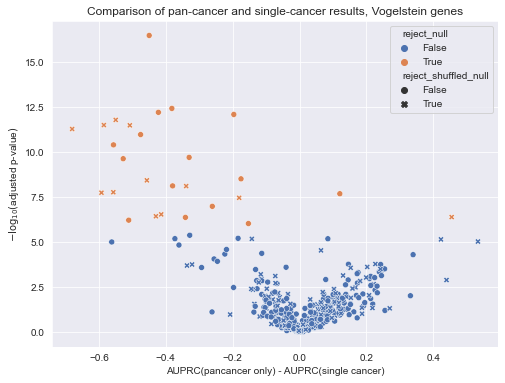

In [8]:
sc_experiment_sig_df['nlog10_p'] = -np.log(sc_experiment_sig_df.p_value)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=sc_experiment_sig_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                style='reject_shuffled_null')
plt.xlabel('AUPRC(pancancer only) - AUPRC(single cancer)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Comparison of pan-cancer and single-cancer results, Vogelstein genes')

In [9]:
experiment_comparison_df = au.compare_results(pancancer_df,
                                              pancancer_df=remove_cancer_df,
                                              identifier='identifier',
                                              metric='aupr',
                                              correction=True,
                                              verbose=False)
experiment_comparison_df.sort_values(by='p_value').head()

,identifier,delta_mean,p_value,corr_pval,reject_null
54,BRAF_THCA,-0.433592,2.815026e-07,0.000117,True
412,SF3B1_UVM,-0.792857,3.991205e-06,0.000569,True
96,TSC1_BLCA,-0.480847,4.091193e-06,0.000569,True
15,KIT_TGCT,-0.577287,1.082450e-05,0.001128,True
379,JAK2_HNSC,-0.514288,2.669630e-05,0.002226,True


In [10]:
# TODO: reset this to local results directory once experiments finish running
results_dir = '/home/jake/data/pancancer_vogelstein_09_25'
pancancer_comparison_df = pd.read_csv(os.path.join(results_dir, 'pancancer_pvals.tsv'),
                                      index_col=False, sep='\t')
overlap = experiment_comparison_df.index.intersection(pancancer_comparison_df.index)
experiment_sig_df = (
    experiment_comparison_df.reindex(overlap)
                            .assign(reject_shuffled_null=pancancer_comparison_df.reject_null)
)
experiment_sig_df.sort_values(by='corr_pval').head(n=15)

,identifier,delta_mean,p_value,corr_pval,reject_null,reject_shuffled_null
54,BRAF_THCA,-0.433592,2.815026e-07,0.000117,True,True
96,TSC1_BLCA,-0.480847,4.091193e-06,0.000569,True,True
15,KIT_TGCT,-0.577287,1.082450e-05,0.001128,True,True
379,JAK2_HNSC,-0.514288,2.669630e-05,0.002226,True,True
3,CDH1_BRCA,-0.372273,6.879986e-05,0.004782,True,False
78,FUBP1_LGG,-0.532884,8.234814e-05,0.004906,True,False
239,IDH1_LGG,-0.171603,1.532609e-04,0.007101,True,False
173,CIC_LGG,-0.539447,1.449188e-04,0.007101,True,True
385,MAP3K1_BRCA,-0.268768,1.979826e-04,0.008256,True,False
125,HRAS_HNSC,-0.544093,2.445824e-04,0.009272,True,True


Text(0.5, 1.0, 'Comparison of "pan-cancer only" and pan-cancer results, Vogelstein genes')

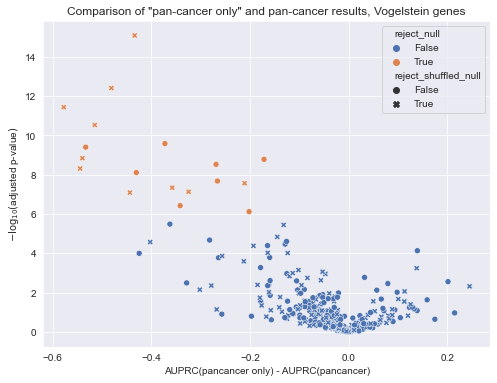

In [11]:
experiment_sig_df['nlog10_p'] = -np.log(experiment_sig_df.p_value)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=experiment_sig_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                style='reject_shuffled_null')
plt.xlabel('AUPRC(pancancer only) - AUPRC(pancancer)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Comparison of "pan-cancer only" and pan-cancer results, Vogelstein genes')

Text(0.5, 1.0, 'Highlight BRAF_THCA in comparison plot')

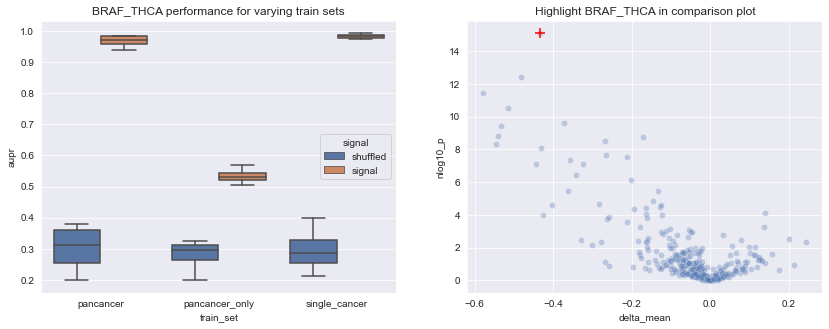

In [12]:
# this is a case where pancancer + THCA comfortably outperforms pancancer without THCA
plot_identifier = 'BRAF_THCA'

# this is a case where pancancer + SKCM slightly outperforms pancancer without SKCM
# but a single-cancer model trained on SKCM alone does best
# plot_identifier = 'BRAF_SKCM'

# these are two cases where pancancer without relevant cancer type does better
# (neither is statistically significant, though)
# plot_identifier = 'NF1_GBM'
# plot_identifier = 'GNAS_BRCA'

results_df = pd.concat((
    single_cancer_df, pancancer_df, remove_cancer_df
))
plot_df = results_df[
    (results_df.identifier == plot_identifier) &
    (results_df.data_type == 'test')
].sort_values(by=['signal', 'train_set'])

sns.set({'figure.figsize': (14, 5)})
fig, axarr = plt.subplots(1, 2)
sns.boxplot(data=plot_df, x='train_set', y='aupr', hue='signal', ax=axarr[0])
sns.scatterplot(data=experiment_sig_df, x='delta_mean', y='nlog10_p',
                alpha=0.3, ax=axarr[1])

def highlight_id(x, y, val, ax, id_to_plot):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['val'] == id_to_plot:
            ax.scatter(point['x'], point['y'], color='red', marker='+', s=100)
        
highlight_id(experiment_sig_df.delta_mean, experiment_sig_df.nlog10_p,
             experiment_sig_df.identifier, axarr[1], plot_identifier)

axarr[0].set_title('{} performance for varying train sets'.format(plot_identifier))
axarr[1].set_title('Highlight {} in comparison plot'.format(plot_identifier))

In [13]:
experiment_sig_df.sort_values(by='delta_mean', ascending=False).head(n=15)

,identifier,delta_mean,p_value,corr_pval,reject_null,reject_shuffled_null,nlog10_p
245,KDM6A_ESCA,0.244844,0.098025,0.648833,False,True,2.322531
176,RB1_SKCM,0.214560,0.378233,0.996655,False,False,0.972246
321,MED12_SKCM,0.201201,0.077117,0.584686,False,False,2.562434
171,STAG2_UCEC,0.174582,0.521204,0.996655,False,False,0.651613
9,GNAS_BRCA,0.158850,0.194647,0.842183,False,False,1.636569
383,ATM_UCEC,0.139062,0.015978,0.214931,False,False,4.136538
43,NF1_GBM,0.138690,0.335512,0.977933,False,False,1.092097
243,ATM_LUSC,0.137733,0.038847,0.395099,False,True,3.248134
229,TSHR_UCEC,0.132575,0.308198,0.977933,False,False,1.177014
334,AR_COAD,0.128979,0.281713,0.953251,False,False,1.266865


Looking at the "volcano plots", we can see that on the whole, models clearly tend to perform worse when the relevant cancer type is removed. This is what we expected to see.

In the above table, looking at the cases where removing the relevant cancer type slightly improves model performance, many of the top results are cancers that are only present in women (e.g. uterine cancer/UCEC, breast cancer/BRCA, ovarian cancer/OV). This isn't always the case, though (ESCA, SKCM, COAD).